In [136]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pyuvdata
import pyuvsim
import uvtools

## Convert beam file to .txt that can be parsed by UVBeam

In [137]:
DIR='001SweepAntennaAngle'
FNAME_BASE='RadiatedElectricField_Freq10MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_in_phase'
FREQ=10*1e6  # 10MHz

In [138]:
fname0=os.path.join('../data/AntennaSimResults', DIR, FNAME_BASE+'_re('+'rEX'+').csv')

In [139]:
def _delete_wrap(data, col=0, period=2*np.pi):
    """
    In case one of the axis is sampled around the circle (eg includes both 0 and 360), we delete the values
    for the second round around the circle
    """
    wrap_idx=np.argwhere(data[:,col] - data[:,col].min() >= period)[:,0]  # rows where the angle wraps around
    if len(wrap_idx):  # axis wraps around
        new_data = np.delete(data, wrap_idx, axis=0)  # delete the given rows
    assert new_data[:,col].max()-new_data[:,col].min() < period
    return new_data

def _rev_indices(data, phi_col, theta_col):
    """
    Convert from phi changing fastest to theta changing fastest (Fortran style to C style)
    """
    ph=data[:, phi_col]
    th=data[:, theta_col]
    new_data = np.empty_like(data)
    for i in range(new_data.shape[1]): # loop over columns
        dcol=data[:,i].copy()
        new_data[:,i]=dcol.reshape(np.unique(ph).size, np.unique(th).size, order='F').flatten(order='C')

    return new_data

def _shift_phi(data, phi_col):
    """
    Change phi from going -pi->pi to 0->2pi 
    """
    phi=data[:,phi_col]
    neg_phi=np.argwhere(phi < 0)[:,0]
    #assert np.allclose(np.diff(neg_phi), np.ones_like(neg_phi)[:-1])
    new_data=data.copy()
    new_data[neg_phi,phi_col] += 2*np.pi
    neg_phi_max = len(neg_phi)
    new_data = np.concatenate((new_data[neg_phi_max:], new_data[:neg_phi_max]))
    assert np.diff(new_data[:, phi_col]).min() >= 0  # phi is still increasing
    assert new_data[:, phi_col].min() >= 0  # and is bigger than 0 everywhere
    return new_data

In [140]:
def load_data(fname):
    
    f = open(fname, 'r')
    header = f.readline().split(",")
    f.close()
    column_names = []
    units = []
    for col in header:
        column_name, unit = tuple(col.split("["))
        column_names.append("".join(column_name.lower().split(" ")))
        units.append(unit.lower().strip())

    data = np.loadtxt(fname, skiprows=1, delimiter=",")
    theta_col = np.where(np.array(column_names) == "theta")[0][0]
    phi_col = np.where(np.array(column_names) == "phi")[0][0]
    volt_col = 2  # should be the last col
    # check that volt col is the last col
    assert not np.isclose(volt_col, phi_col, atol=1e-3)  # not the same as phi
    assert not np.isclose(volt_col, theta_col, atol=1e-3)  # not the same as theta
    assert len(data[0]) == 3  # there are 3 columns, so the last must be volt
    assert 'v' in units[volt_col]  # check the unit to confirm
    
    # convert to radians
    for col in [theta_col, phi_col]:
        if "deg" in units[col]:
            data[:, col] = np.radians(data[:, col])
    if 'mv' in units[volt_col]:
        data[:, volt_col] /= 1e3  # convert mV to V
    
    data = _delete_wrap(data, col=theta_col, period=np.pi)
    data = _delete_wrap(data, col=phi_col, period=2*np.pi)
    
    data = _rev_indices(data, phi_col, theta_col)
    
    data = _shift_phi(data, phi_col)
    
    return data, theta_col, phi_col, volt_col

In [141]:
d,tc, pc, vc = load_data(fname0)

In [142]:
def to_txt(dirpath, fname_base, save=True):
    components=['rEX', 'rEY', 'rEZ']
    fname0=os.path.join('../data/AntennaSimResults', dirpath, fname_base+'_re('+components[0]+').csv')
    data, theta_col, phi_col, volt_col = load_data(fname0)
    power = np.empty((len(data), (len(components)))) 
    theta = data[:, theta_col]
    phi = data[:, phi_col]
    for i, component in enumerate(components):
        real_path=os.path.join('../data/AntennaSimResults', dirpath, fname_base+'_re('+component+').csv')
        im_path=os.path.join('../data/AntennaSimResults', dirpath, fname_base+'_im('+component+').csv')
        power_component = np.zeros_like(power[:, i])
        for path in [real_path, im_path]:
            d, th_col, ph_col, v_col = load_data(path)
            assert np.allclose(d[:, th_col], theta)
            assert np.allclose(d[:, ph_col], phi)
            power_component += d[:, v_col]**2  # square the component to get power
        power[:, i] = power_component
        
    volt_beam=np.sqrt(power.sum(axis=1)) # sum over x,y,z-components
    
    if not save:
        return data
    else:
        outpath=os.path.join('../data/txt_beams', dirpath, fname_base+'.txt')
        if not dirpath in os.listdir('../data/txt_beams'):
            print(f'{dirpath} not found, making dir')
            os.makedirs(os.path.join('../data/txt_beams', dirpath))
        np.savetxt(outpath, data, header='Theta [rad] Phi [rad] Abs(V) [V] \n\n', comments='')

        return outpath

In [143]:
op=to_txt(DIR, FNAME_BASE, save=True)

## Initialize UVBeam object

In [144]:
uvb=pyuvdata.uvbeam.UVBeam()
uvb.read_cst_beam(filename=op, beam_type="power", feed_pol="x", rotate_pol=False,
                  frequency=FREQ, telescope_name='lusee-night', feed_name='monopole', feed_version='1.0',
                  model_name='in-phase', model_version='1.0', history="", x_orientation='north',
                  reference_impedance=50)

In [147]:
uvb.data_array.shape

(1, 1, 1, 1, 180, 90)

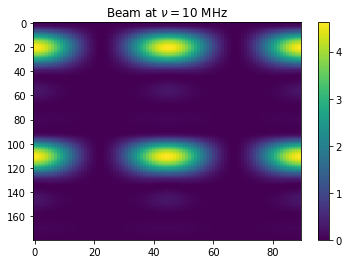

In [149]:
# beam vs phi and theta (data coordinates, extent is [pi/2, 3pi/2, 0, pi])
plt.figure()
uvtools.plot.waterfall(uvb.data_array[0,0,0,0], mode='real')
plt.title('Beam at $\\nu=10$ MHz')
plt.colorbar()
plt.show()

In [146]:
beampath=os.path.join('../data/uvbeams', DIR, FNAME_BASE+'.uvbeam')
uvb.write_beamfits(beampath, clobber=True)

In [95]:
# uvb=pyuvdata.uvbeam.UVBeam()
# uvb.Naxes_vec=3
# uvb.Nfreqs=1
# uvb.Nspws=1  # only supported value
# uvb.antenna_type='simple'
# uvb.bandpass_array=np.zeros((uvb.Nspws, uvb.Nfreqs)) # ?
# uvb.beam_type='efield'
# # feed_pol='xx'
# # rot_pol_dict = {"xx": "yy", "yy": "xx", "xy": "yx", "yx": "xy"}
# # pol2 = rot_pol_dict[feed_pol]
# # uvb.polarization_array = np.array([utils.polstr2num(feed_pol), utils.polstr2num(pol2)])
# # uvb.Npols = len(uvb.polarization_array)
# uvb.Npols=1
# uvb.Naxes2=np.unique(theta).size
# uvb.Naxes1=np.unique(phi).size
#  # shape = Naxes_vec, Nspws, Nfeeds or Npols, Nfreqs, Naxes2, Naxes1
# uvb.data_array=np.empty((uvb.Naxes_vec,uvb.Nspws,uvb.Npols,uvb.Nfreqs,uvb.Naxes2,uvb.Naxes1), dtype=np.complex64)
# for i in range(3):
#     uvb.data_array[i, 0, 0, 0, :, :]=E_field[i].T.copy()
# uvb.data_normalization='physical'
# uvb.feed_name='lusee'
# uvb.feed_version='v1.0'
# uvb.freq_array=np.expand_dims(np.unique(freq)*1e9, axis=0)
# uvb.history=''
# uvb.model_name='inphase_25cm'
# uvb.model_version='v1.0'
# uvb.pixel_coordinate_system='az_za'
# uvb.spw_array=np.array([0])
# uvb.telescope_name='lusee-night'